In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("5-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss,mdp
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2332,1.170060,0.194645,2c9e4172
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2981,1.585207,0.203613,2d304f18
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2981,1.750282,0.208431,12e30c3f
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3712,2.612529,0.210197,47b0e15e
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,1189,0.591845,0.223396,6020b2cd
5,w/ force consider,generic_1,bitcoin,True,False,True,True,False,5,186,0.079336,0.215008,1926ab59
6,w/ force consider,generic_1,ethereum_3,True,False,True,True,False,5,290,0.151904,0.217701,144e6221
7,w/ force consider,generic_1,byzantium_3,True,False,True,True,False,5,290,0.176827,0.217888,575758f7
8,w/ force consider,generic_1,ghostdag_3,True,False,True,True,False,5,350,0.307172,0.217567,437e33c9
9,w/ force consider,generic_1,parallel_3,True,False,True,True,False,5,470,0.244254,0.233822,50222e16


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"5-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                episode_reward_per_progress=episode_reward / episode_progress,
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df.to_pickle("5-value-iterations.pkl.gz")
df

100%|███████████████████████████████████████████| 80/80 [06:18<00:00,  4.74s/it]


,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,episode_reward_per_progress
0,baseline,generic_1,bitcoin,False,False,True,True,False,5,2332,...,0.33,1,0.000997,0.001,1373,0,10.890065,35.829634,98.263813,0.364627
1,baseline,generic_1,ethereum_3,False,False,True,True,False,5,2981,...,0.33,1,0.000999,0.001,1658,0,16.166788,48.278057,98.347990,0.490890
2,baseline,generic_1,byzantium_3,False,False,True,True,False,5,2981,...,0.33,1,0.000999,0.001,1204,0,13.010990,34.567119,98.158175,0.352157
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,5,3712,...,0.33,1,0.000997,0.001,1172,0,14.594684,34.419866,98.339446,0.350011
4,baseline,generic_1,parallel_3,False,False,True,True,False,5,1189,...,0.33,1,0.001000,0.001,1308,0,4.524301,37.891446,96.853811,0.391223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,w/ both,generic_1,bitcoin,True,True,True,True,False,5,120,...,0.66,1,0.000997,0.001,1588,0,0.652182,48.910315,98.704132,0.495524
76,w/ both,generic_1,ethereum_3,True,True,True,True,False,5,186,...,0.66,1,0.000999,0.001,1562,0,0.916249,51.605802,98.687526,0.522921
77,w/ both,generic_1,byzantium_3,True,True,True,True,False,5,186,...,0.66,1,0.000992,0.001,1368,0,0.814070,44.375899,98.535369,0.450355
78,w/ both,generic_1,ghostdag_3,True,True,True,True,False,5,184,...,0.66,1,0.000994,0.001,1064,0,0.633652,39.411062,98.525939,0.400007


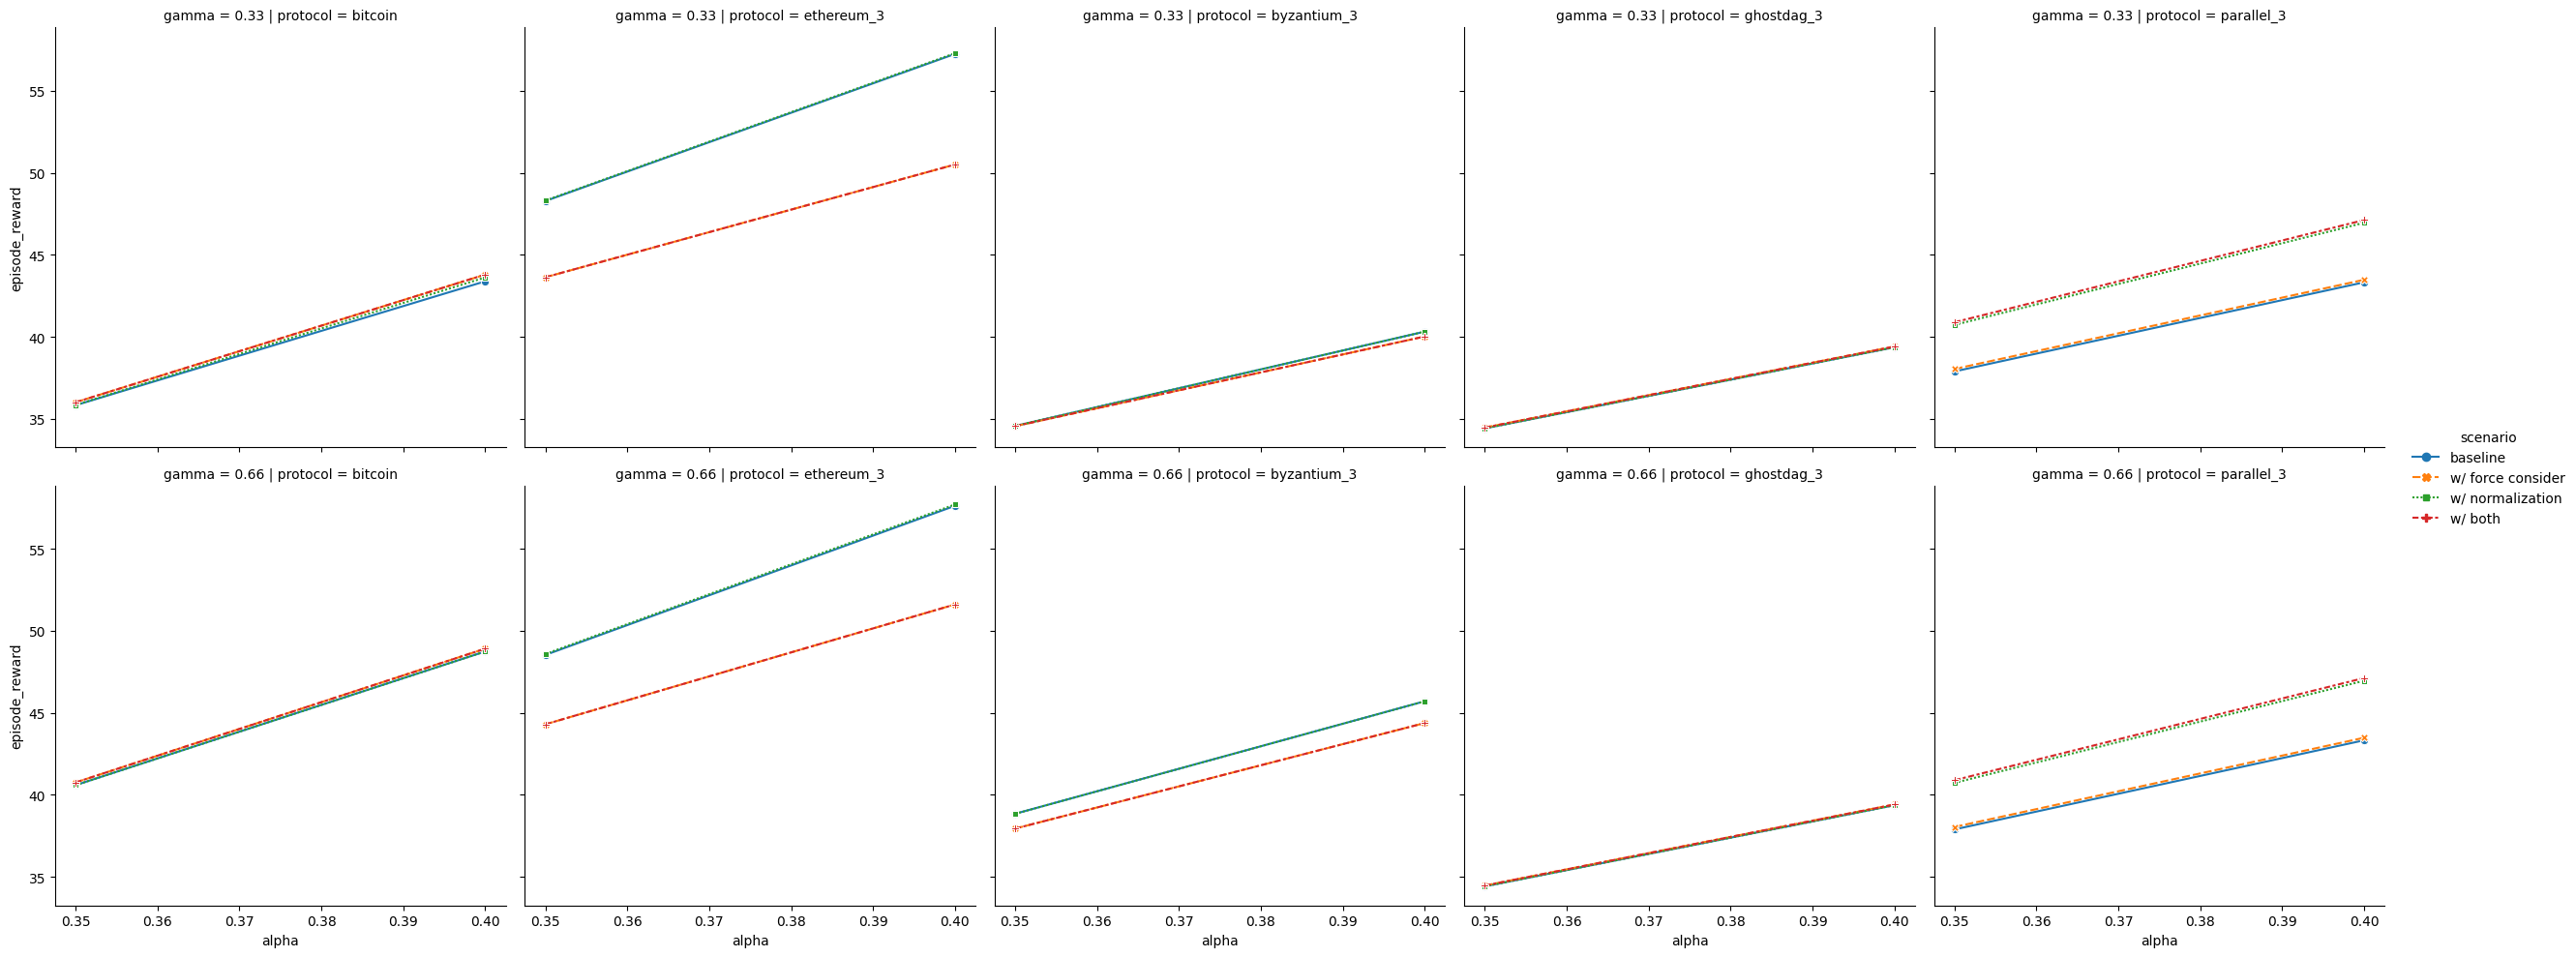

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

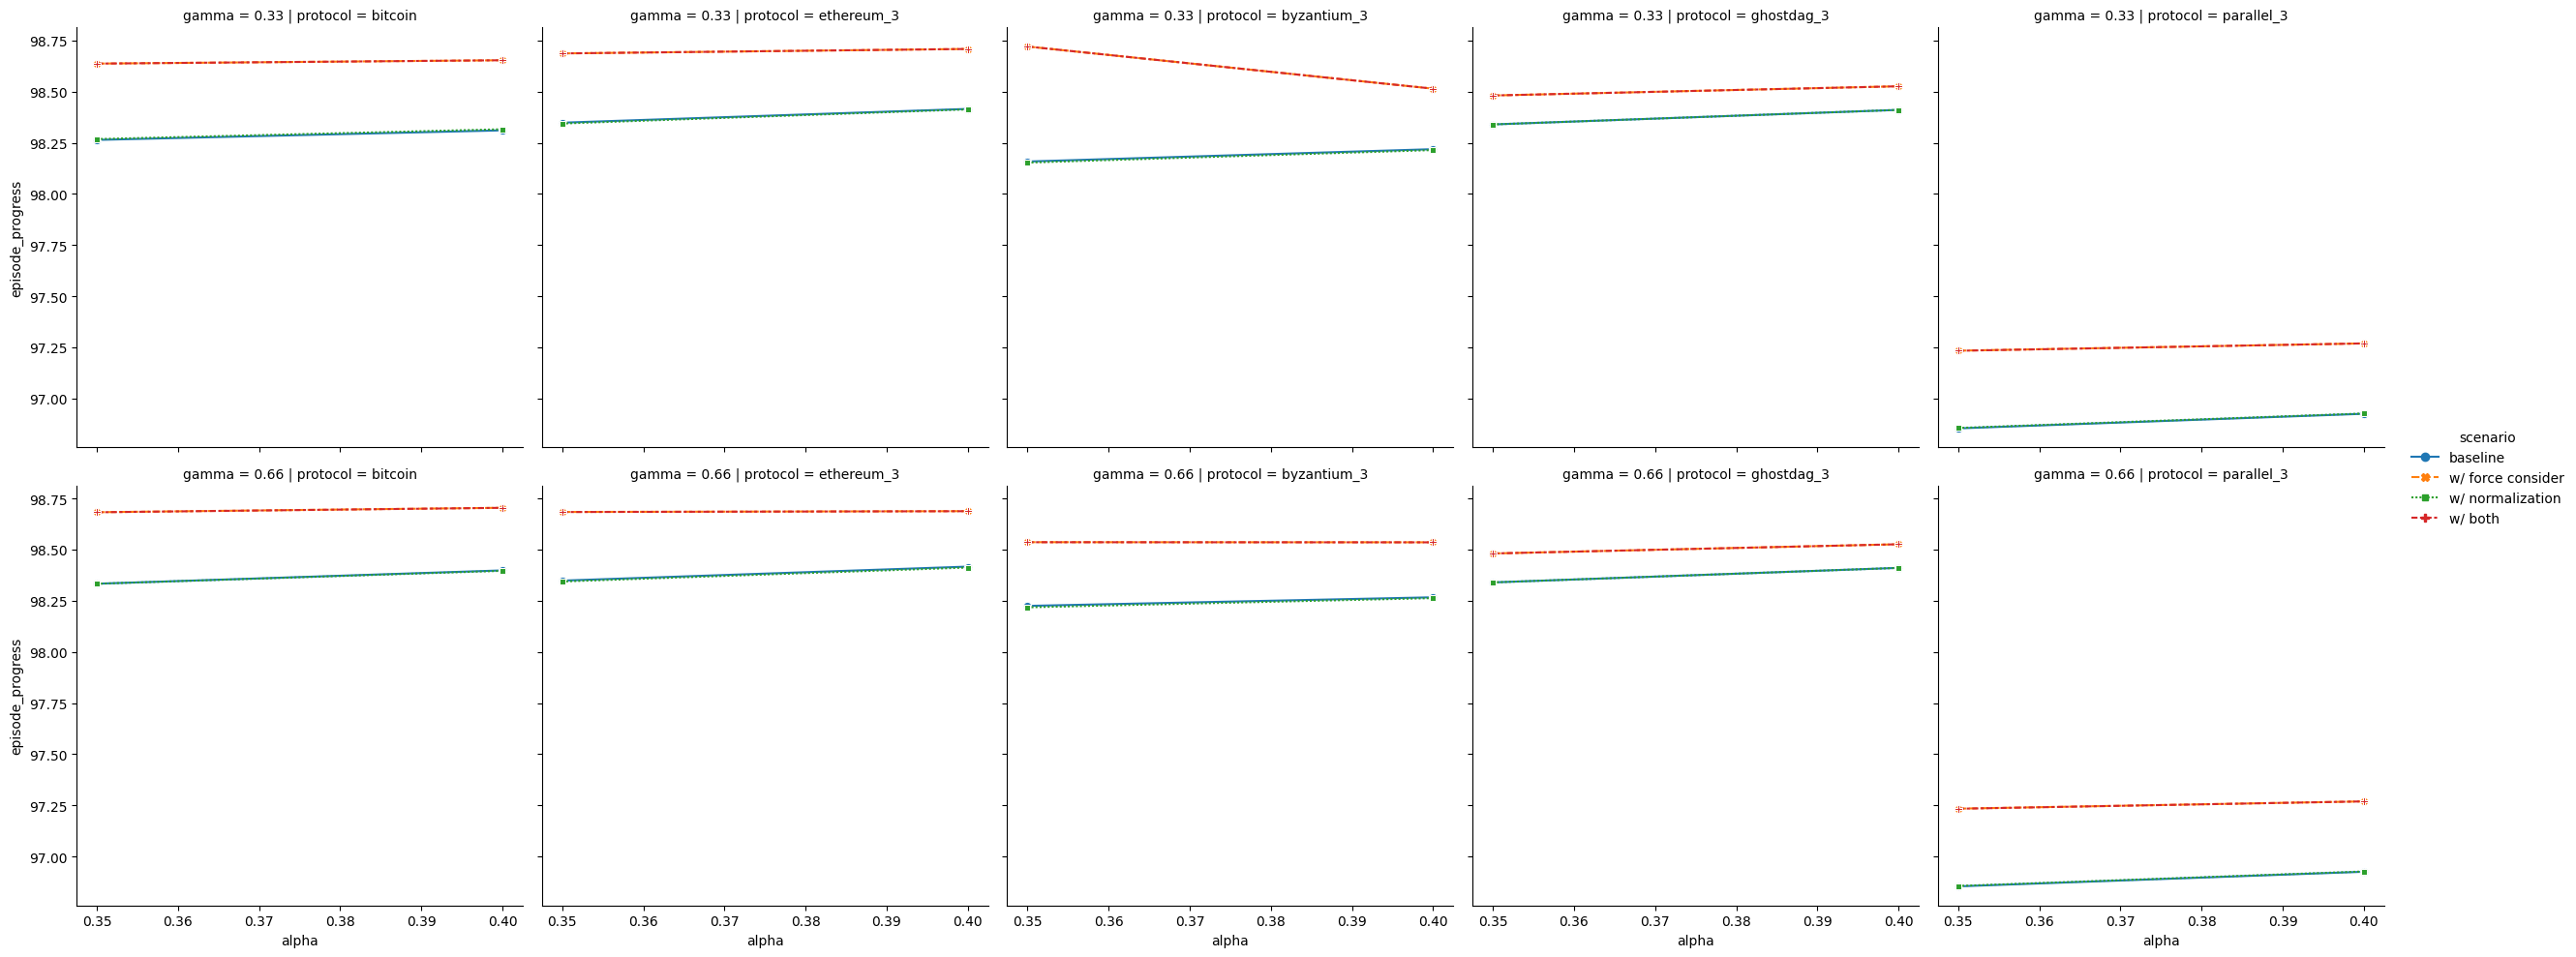

In [6]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

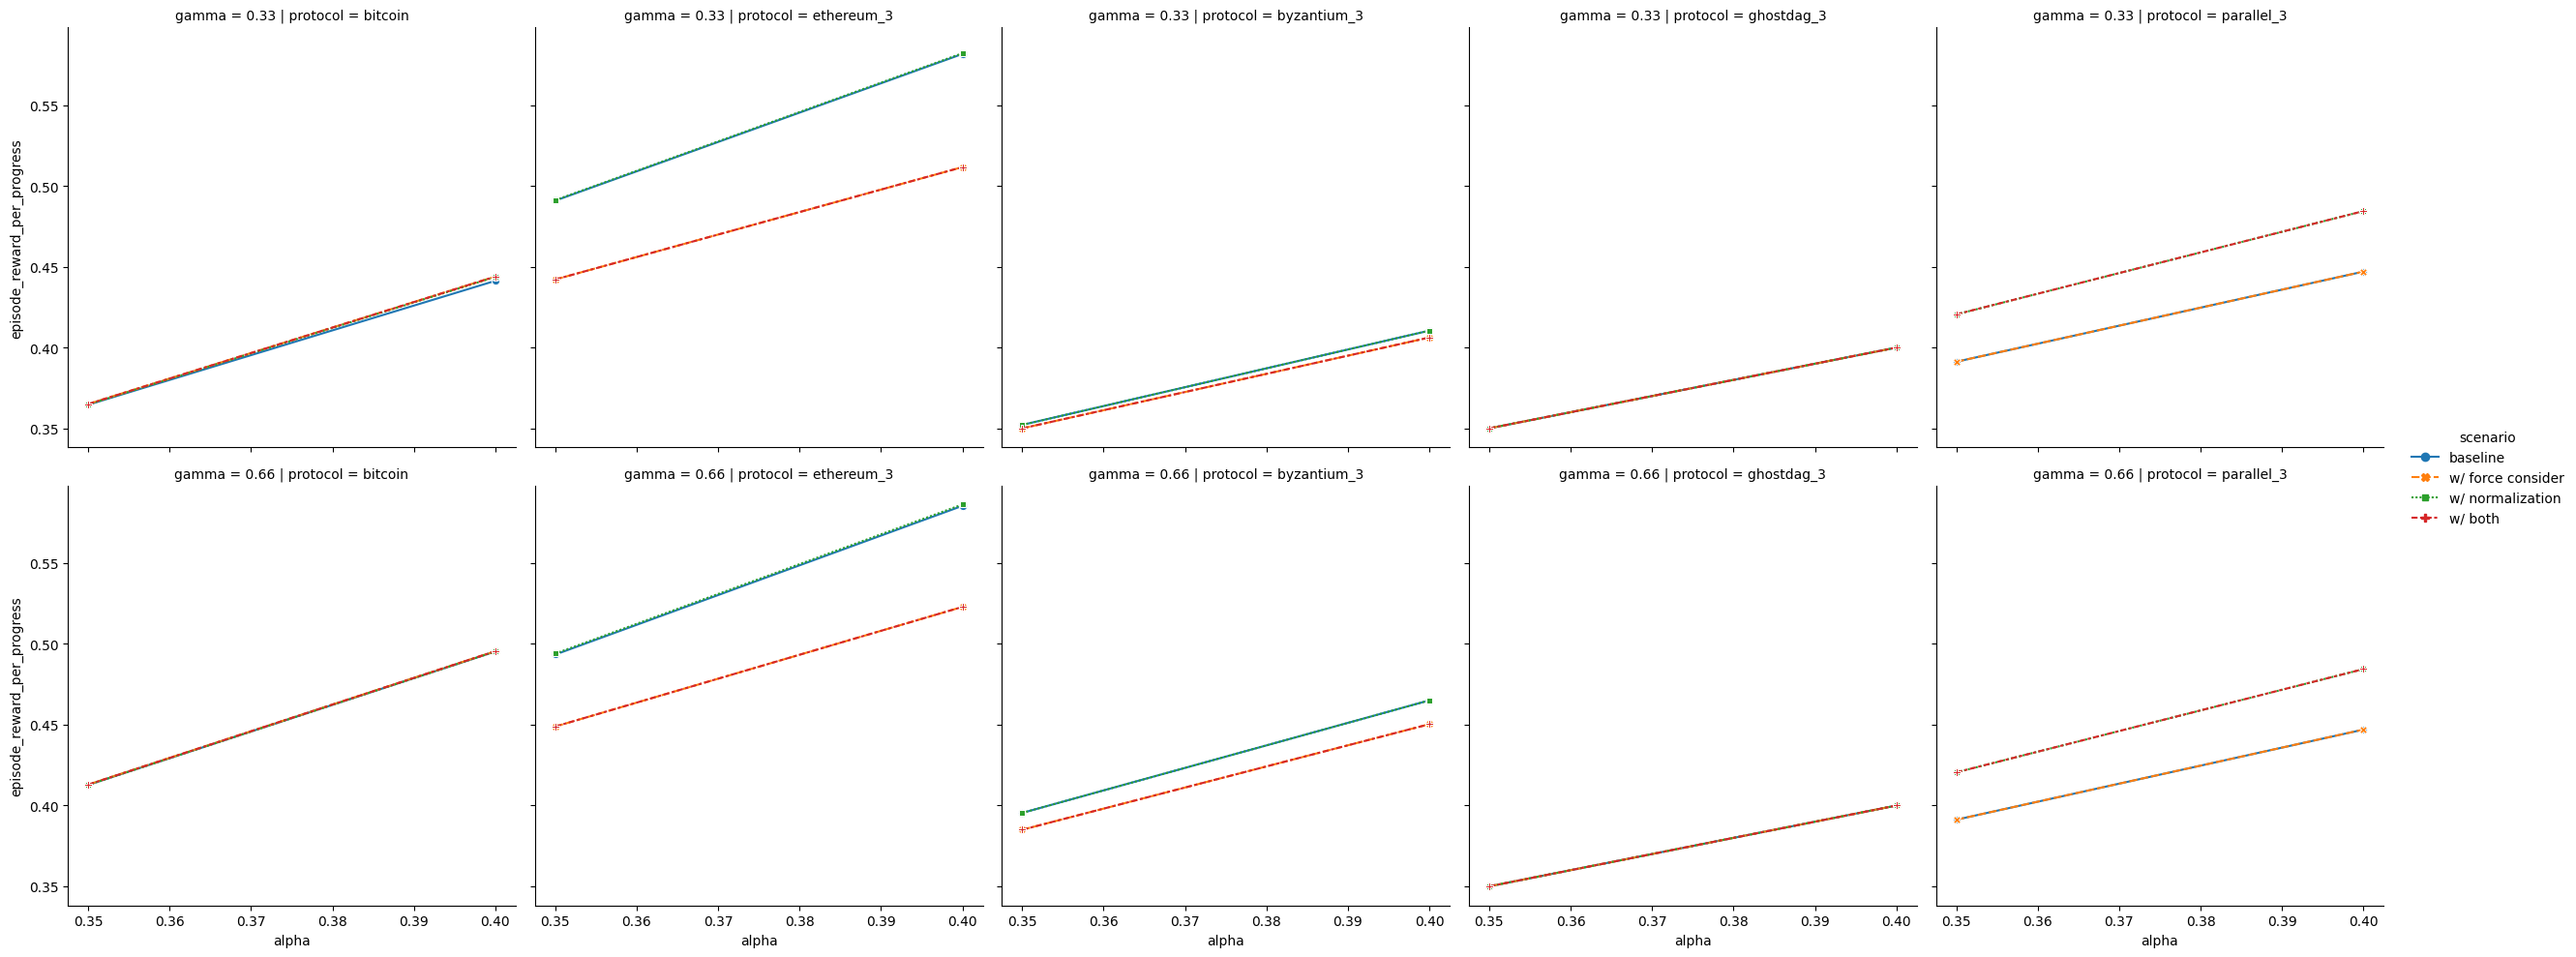

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward_per_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

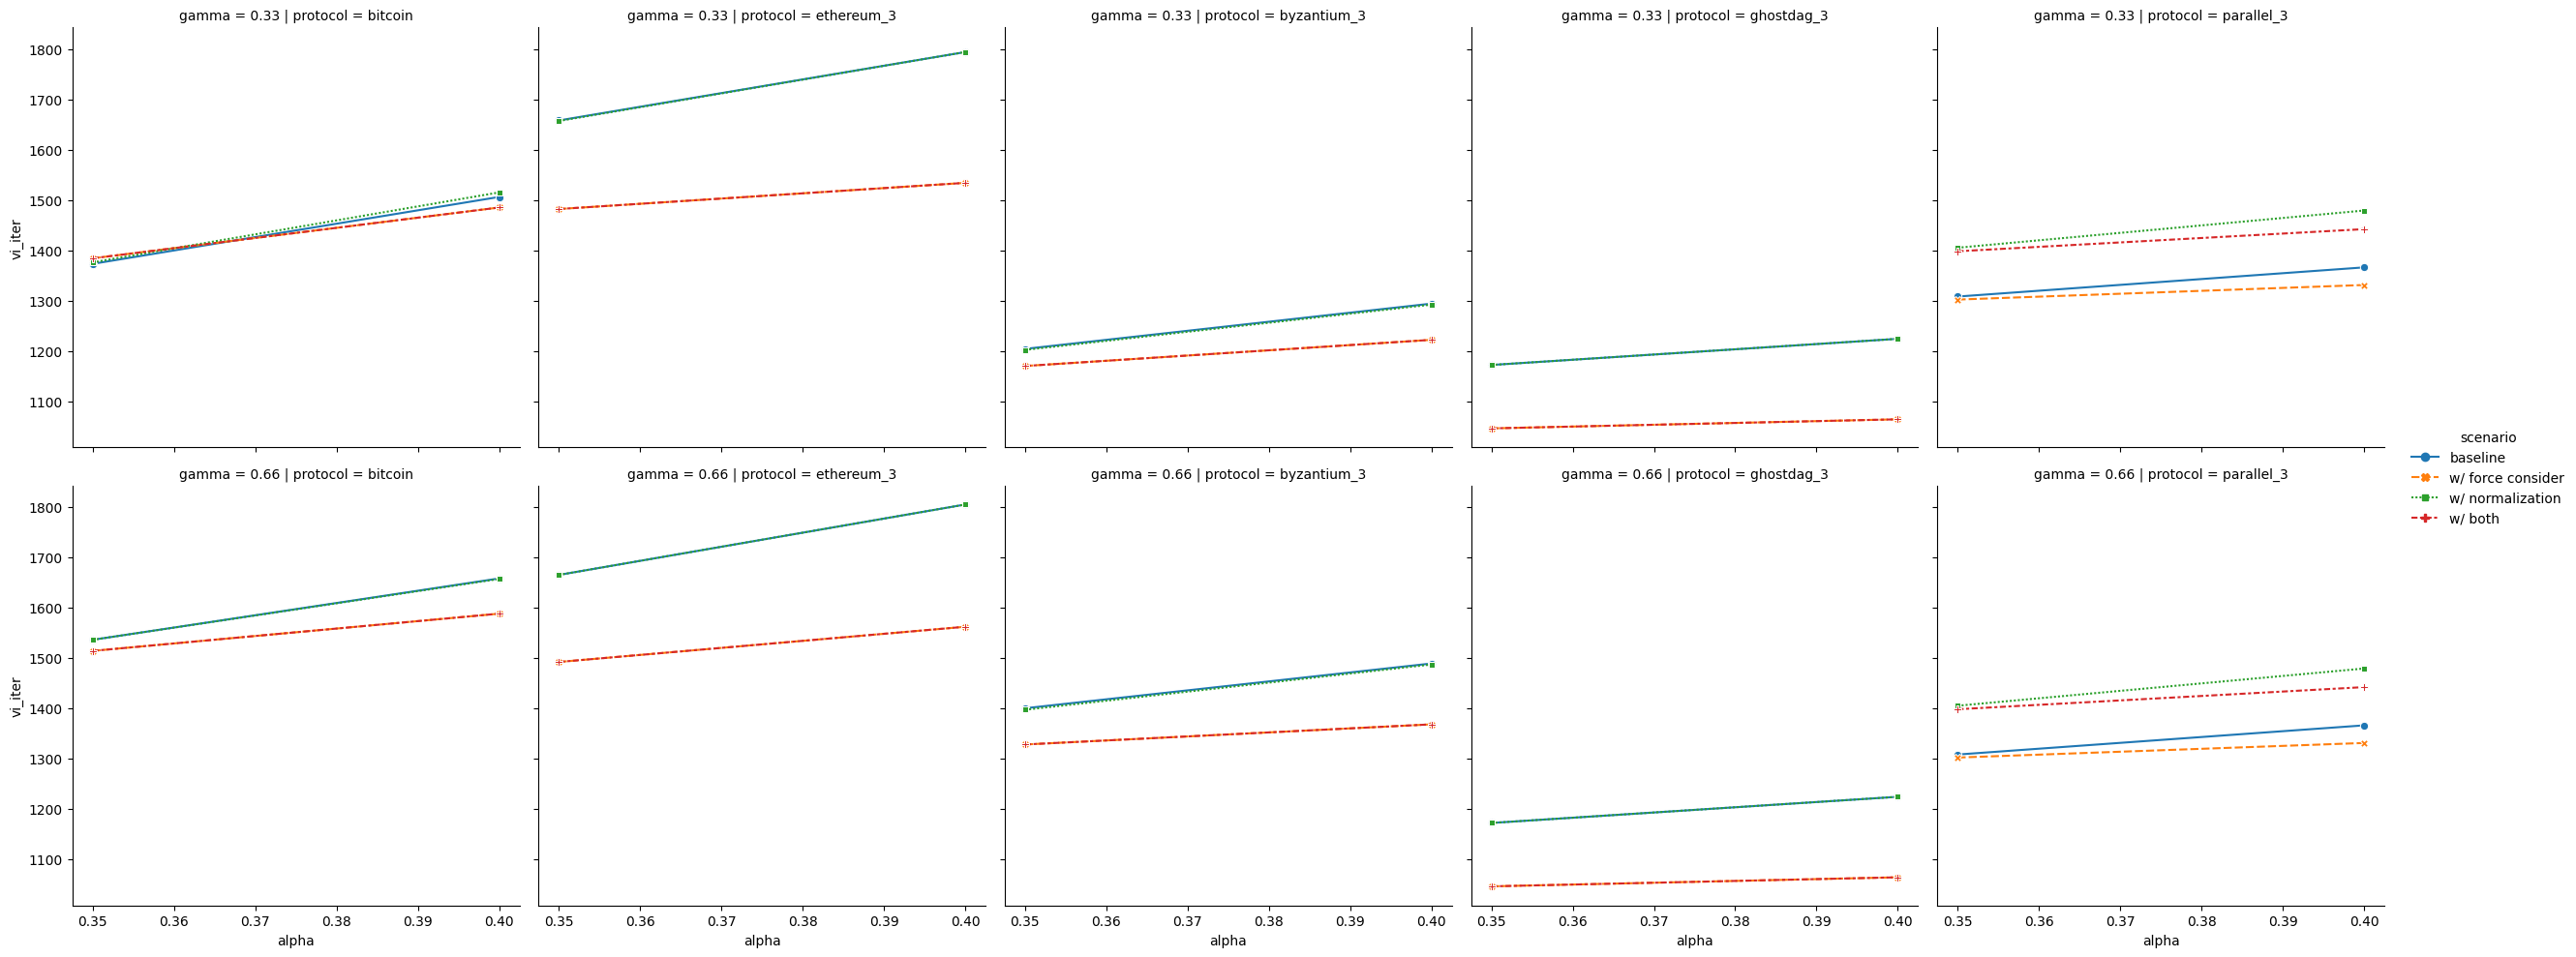

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)